## Correlation Maps

In [4]:
#IMPORTING EVERYTHING NECESSARY
#import matplotlib
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import matplotlib.colors as cl


import numpy as np
from itertools import compress, cycle

import datetime
from scipy.stats import linregress, ttest_1samp, pearsonr
from scipy.io import loadmat
import os
import netCDF4 as nc
from scipy import signal

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from mitgcm_python_master.grid import ERA5Grid, PACEGrid, Grid, dA_from_latlon, pierre_obs_grid
from mitgcm_python_master.file_io import read_binary, write_binary, read_netcdf, netcdf_time, read_title_units, read_annual_average, NCfile
from mitgcm_python_master.utils import real_dir, daily_to_monthly, fix_lon_range, split_longitude, mask_land_ice, moving_average, index_year_start, index_year_end, index_period, mask_2d_to_3d, days_per_month, add_time_dim, z_to_xyz, select_bottom, convert_ismr, mask_except_ice, xy_to_xyz, apply_mask, var_min_max, mask_3d, average_12_months, depth_of_isoline, mask_land, axis_edges
from mitgcm_python_master.plot_utils.colours import set_colours, choose_n_colours, truncate_colourmap
from mitgcm_python_master.plot_utils.windows import finished_plot, set_panels
from mitgcm_python_master.plot_utils.labels import reduce_cbar_labels, round_to_decimals, lon_label
from mitgcm_python_master.plot_utils.latlon import shade_mask, overlay_vectors
from mitgcm_python_master.plot_utils.slices import slice_patches, slice_values
#from mitgcm_python_master.plot_1d import default_colours, make_timeseries_plot_2sided, timeseries_multi_plot, make_timeseries_plot
from mitgcm_python_master.plot_latlon import latlon_plot
#from mitgcm_python_master.plot_slices import slice_plot, make_slice_plot
from mitgcm_python_master.constants import sec_per_year, kg_per_Gt, dotson_melt_years, getz_melt_years, pig_melt_years, region_names, deg_string, sec_per_day, region_bounds, Cp_sw, rad2deg, rhoConst, adusumilli_melt, rho_fw
#from mitgcm_python_master.plot_misc import hovmoller_plot, ts_animation, ts_binning
from mitgcm_python_master.timeseries import calc_annual_averages, set_parameters
from mitgcm_python_master.postprocess import get_output_files, check_segment_dir, segment_file_paths, set_update_file, set_update_time, set_update_var, precompute_timeseries_coupled
from mitgcm_python_master.diagnostics import adv_heat_wrt_freezing, potential_density, thermocline
from mitgcm_python_master.calculus import time_derivative, time_integral, vertical_average, area_average
from mitgcm_python_master.interpolation import interp_reg_xy, interp_to_depth, interp_grid, interp_slice_helper, interp_nonreg_xy


In [5]:
def quadratic_detrending(data):
    '''
    Make sure that no NaN cells are present!
    '''    
    X=np.arange(len(data))
    y=data
    pf = PolynomialFeatures(degree=2)
    Xp = pf.fit_transform(X.reshape(-1,1))
    md2 = LinearRegression()
    md2.fit(Xp, y)
    trendp = md2.predict(Xp)
    #fit=pd.series(trendp, index=data.index)
    detrended=data-trendp
    
    return detrended


def correlate_timeseries_with_map_full_ensemble (pace_dir, grid_path, timeseries_file='timeseries_final.nc', fig_dir='./', 
                                                 timeseries=['dotson_to_cosgrove_massloss'], mapvar='EXFuwind', 
                                                 title='Correlation map of local surface winds with melt between Dotson and Cosgrove', 
                                                 region='amundsen_sea', detrend=False, method='linear', show_vectors=False, 
                                                 new_data=False, file=None,
                                                 new_v_data=False, vfiles=None, save=True):
    from datetime import date
    today = date.today()
    
    if new_data==True:
        print('Computing Mean R Data')
        forcing_names = timeseries
        num_forcing = len(forcing_names)
        base_year_start = 1920
        base_year_end = 1949    
        num_ens = len(pace_dir)
        output_dir = [real_dir(d) + 'output/' for d in pace_dir]
        ts_paths = [od + timeseries_file for od in output_dir]
        smooth = 24
        max_lag = 24
        ymax = -70
        fig_dir = real_dir(fig_dir)

        grid = Grid(grid_path)
        region=region

        mask = grid.get_region_mask(region)
        mask=mask.astype(bool)
        num_ice_pts = np.count_nonzero(mask)
        print('Num_ice_pts:'+str(num_ice_pts))

        # Get time indices of the base period
        time = netcdf_time(ts_paths[0], monthly=False)
        t_start, t_end = index_period(time, base_year_start, base_year_end)

        # Read and process the ice shelf melt rates
        print('Reading surface winds')
        ismr_data = None    
        for n in range(num_ens):
            print(('...' + pace_dir[n]))
            ismr_tmp = None
            file_paths = segment_file_paths(output_dir[n])
            for f in file_paths:
                ismr_1y = mask_land_ice(read_netcdf(f, mapvar), grid, time_dependent=True)
                if ismr_tmp is None:
                    ismr_tmp = ismr_1y
                else:
                    ismr_tmp = np.concatenate((ismr_tmp, ismr_1y), axis=0)
            # Trim the spinup
            ismr_tmp = ismr_tmp[t_start:,:]
            # Get 2 year running mean
            ismr_tmp = moving_average(ismr_tmp, smooth)
            # Centre the data by subtracting the time-mean at each point
            ismr_tmp -= np.mean(ismr_tmp, axis=0)
            if detrend==True:
                if method=='linear':
                    for i in range(len(ismr_tmp[0,:])):
                        ismr_tmp[:,i]=signal.detrend(ismr_tmp[:,i])
                if method=='quadratic':
                    for i in range(len(ismr_tmp[0,:])):
                        ismr_tmp[:,i]=quadratic_detrending(ismr_tmp[:,i])

            # Save to master array, but only the ice shelf points
            if ismr_data is None:
                num_time = ismr_tmp.shape[0]
                ismr_data = np.ma.empty([num_ens, num_time, num_ice_pts])
            ismr_data[n,:] = ismr_tmp[:,mask]

            
        # Now process one forcing at a time
        for m in range(num_forcing):
            print(('Processing ' + forcing_names[m]))
            print('Reading forcing timeseries and calculating lags')
            forcing_data = np.empty([num_ens, num_time])

            for n in range(num_ens):
                print(('...'+pace_dir[n]))
                # Read and process the timeseries
                data_tmp = read_netcdf(ts_paths[n], forcing_names[m])            
                if forcing_names[m] == 'amundsen_shelf_break_uwind_avg':
                    # Time-integral of wind anomaly from 1920-1949 mean
                    data_tmp -= np.mean(data_tmp[t_start:t_end])
                    dt = 365./12*sec_per_day
                    data_tmp = np.cumsum(data_tmp*dt)
                # Trim the spinup
                data_tmp = data_tmp[t_start:]
                # Get 2 year running mean
                data_tmp = moving_average(data_tmp, smooth)
                # Now centre the data by subtracting the mean
                data_tmp -= np.mean(data_tmp)
                
                if n==0:
                  plt.figure()
                  for n in range(num_ens):
                    plt.subplot(1,1,1)
                    plt.plot(data_tmp)
                    plt.legend()
                  plt.savefig('test_ts_original.png')  
                # Save to master array
                if detrend==True:
                    if method=='linear':
                        data_tmp=signal.detrend(data_tmp)
                    if method=='quadratic':
                        data_tmp=quadratic_detrending(data_tmp)
                forcing_data[n,:] = data_tmp

            #Loop over ice shelf points
            #lag = np.empty(num_ice_pts)
            #for p in range(num_ice_pts):
                # Extract timeseries of ice shelf melting at this point
            #    ismr_ts = ismr_data[:,:,p].flatten()
                # Calculate cross-correlation with forcing
            #    corr = np.correlate(forcing_data[:,:].flatten(), ismr_ts, mode='full')
                # Get best lag period: peak in correlation, shifted to account for different sized arrays (as in https://stackoverflow.com/questions/49372282/find-the-best-lag-from-the-numpy-correlate-output)
                # Do the shift first by trimming all indices that would lead to a negative lag, or a lag larger than the maximum
            #    corr = corr[num_time-1-max_lag:] #ADDED BY JOREN: ADD NEGATIVE LAG
            #    corr = corr[:max_lag+1]

            #    lag[p] = np.argmax(corr)-max_lag #ADDED BY JOREN: ADJUST FOR NEGATIVE LAG
            # Now calculate average lag over all points, and save to master array
            #avg_lag = np.mean(lag)
            # Calculate average lag over all ensemble members and round to nearest int
            #final_lag = int(np.round(np.mean(avg_lag)))
            final_lag=-15
            
            print(('Optimum lag of ' + str(final_lag) + ' months'))

            # Now get ensemble-mean correlation coefficients for each point and each member
            print('Calculating correlation coefficients')
            mean_r = np.empty(num_ice_pts)
            for p in range(num_ice_pts):
                #if p==100:
                  #plt.figure()
                r_values = np.empty(num_ens)
                #for n in range(num_ens):
                    # Extract the two timeseries and shift by the correct lag
                if final_lag<0: #ADDED BY JOREN
                    forcing_ts = forcing_data[:,-final_lag:]
                    ismr_ts = ismr_data[:,:final_lag,p]
                elif final_lag>=0: #ADDED BY JOREN
                    if final_lag==0:
                        print('Oops.............')
                    forcing_ts = forcing_data[:,:-final_lag]
                    ismr_ts = ismr_data[:,final_lag:,p]
                # Now do the linear regression
                #r_values[n] = linregress(forcing_ts, ismr_ts)[2]
                    #if p==100:
                      #plt.subplot(2,2,n+1)
                      #plt.scatter(forcing_ts, ismr_ts)

                # Take mean over ensemble members
                if p==100:
                  plt.figure()
                  for n in range(num_ens):
                    plt.subplot(2,1,1)
                    plt.plot(ismr_ts[n,:], label=n)
                    plt.legend()
                    plt.subplot(2,1,2)
                    plt.plot(forcing_ts[n,:], label=n)
                    plt.legend()
                  plt.savefig('test_ts_dt.png')            

                  plt.figure()
                  for n in range(num_ens):
                    plt.scatter(forcing_ts[n,:], ismr_ts[n,:], label=n)
                  plt.legend()
                  plt.savefig('test_corrs.png')

                forcing_ts=forcing_ts.flatten()
                ismr_ts=ismr_ts.flatten()
                mean_r[p] = linregress(forcing_ts, ismr_ts)[2]
                
                if save==True:
                    print('Saving Mean R Data')
                    if detrend==True:
                        np.save('./data/mean_r_'+mapvar+'_'+timeseries[0][0:3]+timeseries[0][-4:]+'_'+method+'_num'+str(len(pace_dir))+'_'+today.strftime("%Y%m%d")+'.npy', mean_r)
                    else:
                        np.save('./data/mean_r_'+mapvar+'_'+timeseries[0][0:3]+timeseries[0][-4:]+'_num'+str(len(pace_dir))+'_'+today.strftime("%Y%m%d")+'.npy', mean_r)
        # Convert this array to lon-lat and fill in the mask
        
    else:
        print('Loading Mean R Data')
        mean_r=np.load(file)
        
    r_data = np.zeros([grid.ny, grid.nx])
    r_data[mask] = mean_r
    r_data = mask_land_ice(r_data, grid)
    print(('Mean r over all points and ensemble members = '+str(np.mean(r_data))))


    vmin=np.min(r_data[mask])
    vmax=np.max(r_data[mask])      

    fig, ax=plt.subplots(figsize=(14,5))
    latlon_plot(r_data, grid, ctype='plusminus', ymax=ymax, vmin=None, vmax=None, title=title+' at optimum lag of '+str(final_lag)+' months', titlesize=14, figsize=(14,5), ax=ax)
    r=ax.contour(grid.lon_2d, grid.lat_2d, r_data, levels=[0, 0.25, 0.5], colors=['yellow'])
    plt.clabel(r, [0, 0.25, 0.5])

    bath=ax.contour(grid.lon_2d, grid.lat_2d, grid.bathy, levels=[-1000], colors=['black'])
    plt.clabel(bath, [-1000])
        
        #%%------------SHOW VECTORS-------------------------------------------------------------
    if show_vectors==True:
        if mapvar=='EXFuwind':
            if new_v_data==True:
                print('Computing V Data')
                print('Reading the extra data for vectors.... (might take a very long time)')
                for k, mv in enumerate(['EXFuwind', 'EXFvwind']):
                    ismr_data=None
                    for n in range(num_ens):
                        print(mv)
                        print(('...' + pace_dir[n]))
                        ismr_tmp = None
                        file_paths = segment_file_paths(output_dir[n])
                        for f in file_paths:
                            ismr_1y = mask_land_ice(read_netcdf(f, mv), grid, time_dependent=True)
                            if ismr_tmp is None:
                                ismr_tmp = ismr_1y
                            else:
                                ismr_tmp = np.concatenate((ismr_tmp, ismr_1y), axis=0)
                        # Trim the spinup
                        ismr_tmp = ismr_tmp[t_start:,:]
                        if ismr_data is None:
                            num_time = ismr_tmp.shape[0]
                            ismr_data = np.ma.empty([num_ens, num_time, num_ice_pts])
                        ismr_data[n,:] = ismr_tmp[:,mask]

                    vx_data=np.nanmean(ismr_data, axis=0)
                    vx_data=np.nanmean(vx_data, axis=0)
                    if k==0:
                        vx = np.zeros([grid.ny, grid.nx])
                        vx[mask] = vx_data
                        vx=mask_land_ice(vx, grid)
                    else:
                        vy = np.zeros([grid.ny, grid.nx])
                        vy[mask] = vx_data
                        vy=mask_land_ice(vy, grid)
                    if save==True:
                        np.save('./data/vx_'+mapvar+'_'+'_num'+str(len(pace_dir))+'_'+today.strftime("%Y%m%d")+'.npy', vx)
                        np.save('./data/vy_'+mapvar+'_'+'_num'+str(len(pace_dir))+'_'+today.strftime("%Y%m%d")+'.npy', vy)
            else:
                print('Loading Mean V Data')
                vx=np.load(vfiles[0])
                vy=np.load(vfiles[1])
                    #ismr_data=None
                #mapvar2='EXFvwind'
                #for n in range(num_ens):
                    #print(mapvar2)
                    #print(('...' + pace_dir[n]))
                    #ismr_tmp = None
                    #file_paths = segment_file_paths(output_dir[n])
                    #for f in file_paths:
                       # ismr_1y = mask_land_ice(read_netcdf(f, mapvar2), grid, time_dependent=True)
                       # if ismr_tmp is None:
                       #     ismr_tmp = ismr_1y
                      #  else:
                     #       ismr_tmp = np.concatenate((ismr_tmp, ismr_1y), axis=0)
                    # Trim the spinup
                    #ismr_tmp = ismr_tmp[t_start:,:]
                    #if ismr_data is None:
                      #  num_time = ismr_tmp.shape[0]
                     #   ismr_data = np.ma.empty([num_ens, num_time, num_ice_pts])
                    #ismr_data[n,:] = ismr_tmp[:,mask]

                  #print(np.shape(ismr_data))
                #vy_data=np.nanmean(ismr_data, axis=0)
                #print(np.shape(vy_data))
                #vy_data=np.nanmean(vy_data, axis=0)


                #vy = np.zeros([grid.ny, grid.nx])
                #vy[mask] = vy_data
                #vy=mask_land_ice(vy, grid)
                #overlay_vectors(ax, vx, vy, grid, chunk_x=9, chunk_y=6, scale=None, headwidth=4, headlength=5)
            overlay_vectors(ax, vx, vy, grid, chunk_x=40, chunk_y=40, scale=1e2, headwidth=2, headlength=3)
                
        finished_plot(fig, fig_name=fig_dir+'correlation_map_'+timeseries[m]+'_'+mapvar+'_KaitlinsMethod.png', dpi=300)
        return

['/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE02', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE03', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE04', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE05', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE06', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE07', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE08', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE09', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE10', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE11', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE12', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE13', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE14', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE15', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE16', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE17', '/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE18', '/data/oceans_output/shelf/

.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE02
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE03
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE04
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE05
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE06
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE07
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE08
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE09
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE10
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE11
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE12
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE13
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE14
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE15
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE16
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE17
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE18
.../data/oceans_output/shelf/kaight/mitgcm/PAS_PACE19
.../data/oceans_output/shelf

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_75601/1833808145.py", line 13, in <module>
    correlate_timeseries_with_map_full_ensemble (pace_dir=pd, grid_path=gp, timeseries_file=tf, fig_dir='./',
  File "/tmp/ipykernel_75601/2174225329.py", line 130, in correlate_timeseries_with_map_full_ensemble
    corr = np.correlate(forcing_data[:,:].flatten(), ismr_ts, mode='full')
  File "<__array_function__ internals>", line 5, in correlate
  File "/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/numpy/core/numeric.py", line 741, in correlate
    return multiarray.correlate2(a, v, mode)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/IPython/core/

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_75601/1833808145.py", line 13, in <module>
    correlate_timeseries_with_map_full_ensemble (pace_dir=pd, grid_path=gp, timeseries_file=tf, fig_dir='./',
  File "/tmp/ipykernel_75601/2174225329.py", line 130, in correlate_timeseries_with_map_full_ensemble
    corr = np.correlate(forcing_data[:,:].flatten(), ismr_ts, mode='full')
  File "<__array_function__ internals>", line 5, in correlate
  File "/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/numpy/core/numeric.py", line 741, in correlate
    return multiarray.correlate2(a, v, mode)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/IPython/core/

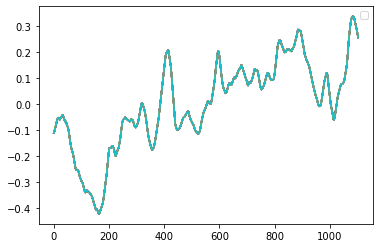

In [ ]:
bd='/data/oceans_output/shelf/kaight/mitgcm'
gp='/data/oceans_output/shelf/kaight/mitgcm/PAS_grid/'
tf='timeseries_final.nc'
pd=[os.path.join(bd, f) for f in os.listdir(bd) if ('PAS_PACE' in f) & ('hb' not in f)]
print(pd)

new=True
save=False
show_vectors=False

#I fixed the lag to -15!!!!!!!!!!!!!!

if new==True:
    print('Starting with new data')
    correlate_timeseries_with_map_full_ensemble (pace_dir=pd, grid_path=gp, timeseries_file=tf, fig_dir='./', 
                                                 region='amundsen_sea', detrend=True, method='quadratic',
                                                 timeseries=['amundsen_shelf_temp_btw_200_700m'], mapvar='EXFuwind',
                                                 show_vectors=show_vectors,
                                                 title='Correlation map of local zonal surface winds with Amundsen Shelf Temperatures (200-700m) \n (both 24 moving average, quadratic detrended) (full ensemble)',
                                                 new_data=True, new_v_data=True, save=save)
else:
    print('Starting with loading data')
    correlate_timeseries_with_map_full_ensemble (pace_dir=pd, grid_path=gp, timeseries_file=tf, fig_dir='./', 
                                                 region='amundsen_sea', detrend=True, method='quadratic',
                                                 timeseries=['amundsen_shelf_temp_btw_200_700m'], mapvar='EXFuwind',
                                                 show_vectors=True,
                                                 title='Correlation map of local zonal surface winds with Amundsen Shelf Temperatures (200-700m) \n (both 24 running mean) (All members)',
                                                 new_data=False, file='./data/mean_r...npy',
                                                 new_v_data=False, vfiles=['./data/vx...npy', './data/vy...npy'])


<a list of 1 text.Text objects>

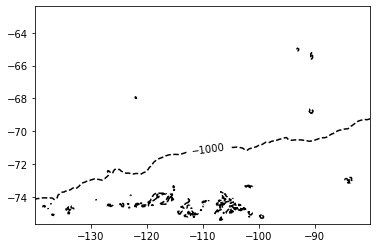

In [26]:
a=Grid(gp)
b=plt.contour(a.lon_2d, a.lat_2d, a.bathy, levels=[-1000], colors=['black'])
plt.clabel(b, [-1000])

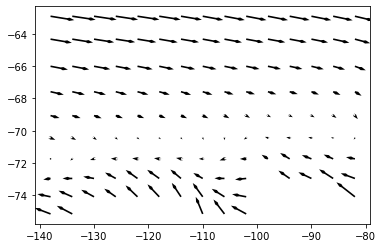

In [73]:
ax=plt.subplot(1,1,1)
overlay_vectors(ax, vx, vy, grid, chunk_x=40, chunk_y=40, scale=1e2, headwidth=2, headlength=3)